# Image Classification with CNN using Keras

# Task 1: Import Libraries

In [1]:
import tensorflow as tf
import os
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')
    
print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.0.1
Is using GPU? False


# Task 2: Preprocess Data

In [2]:
def get_three_classes(x, y):
    indices_0, _ = np.where(y == 0.) #return indices where y is 0 ,1,2
    indices_1, _ = np.where(y == 1.)
    indices_2, _ = np.where(y == 2.)

    indices = np.concatenate([indices_0, indices_1, indices_2], axis=0) #concatenate indices along first axis
    
    x = x[indices] #select example and labels to those indices
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False) #shuffle indices
    #count number of choices and it will return, we don't want anything to repeat
    
    x = x[indices] #shuffle indices
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y) #labels to one hot encoding
    
    return x, y

#10 classes and 60000 training and 10000 testing
#subset of this dataset - 3 classes and 15000 examples in train set

In [3]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.cifar10.load_data()

x_train,y_train = get_three_classes(x_train,y_train)
x_test,y_test = get_three_classes(x_test,y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape,y_test.shape) #images are small 32 x 32

(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


# Task 3: Visualize Examples

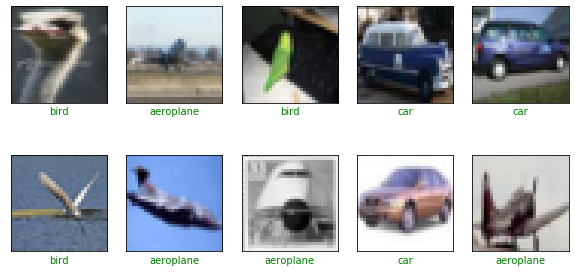

In [4]:
class_names = ['aeroplane', 'car', 'bird']


def show_random_examples(x,y,p): #x y examples and labels and p as prediction
    indices=np.random.choice(range(x.shape[0]),10,replace=False) #list of all choices that are unique
    
    x=x[indices]
    y=y[indices]
    p=p[indices]
    
    plt.figure(figsize=(10,5))
    for i in range(10):
        plt.subplot(2,5,1+i)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        
        col='green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red' 
        #if same as ground truth else red
        
        plt.xlabel(class_names[np.argmax(p[i])],color=col)
    plt.show()
    
show_random_examples(x_train,y_train,y_train)


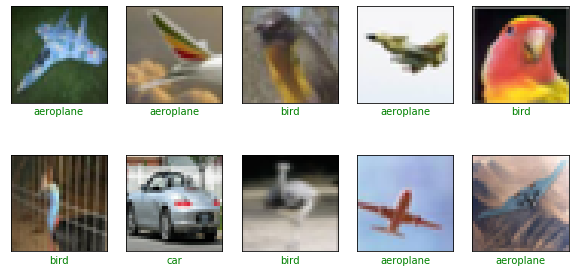

In [5]:
#from test dataset
show_random_examples(x_test,y_test,y_test)

# Task 4: Create Model

In [8]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

def create_model():
    def add_conv_block(model,num_filters): # take into account model and number of filters
        model.add(Conv2D(num_filters,3,activation='relu',padding='same'))
        model.add(BatchNormalization()) # for regularization and not much covariance shift in the output of preceding layer
        model.add(Conv2D(num_filters,3,activation='relu')) #padding is default, rows/columns are reduced here
        model.add(MaxPooling2D(pool_size=2)) #reduce rows.columns to half of original values
        model.add(Dropout(0.5))
        return model
    
    model=tf.keras.models.Sequential()
    model.add(Input(shape=(32,32,3))) #input layer
    
    model = add_conv_block(model,32) # filter 32
    model = add_conv_block(model,64) #filter 64
    model = add_conv_block(model,128) #filter 128
    
    model.add(Flatten())
    model.add(Dense(3,activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',metrics=['accuracy']
    )
    
    return model

model = create_model()
model.summary()
    

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 15, 15, 64)       

# Task 5: Train the Model

In [12]:
h = model.fit(
    x_train/255.,y_train, #normalization
    validation_data=(x_test/255.,y_test),
    epochs=10, batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3), #if validation is not improved for 3 epochs then we can stop the program
        tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy: .3f}.h5',
                                          save_best_only=True, save_weights_only=False,
                                          monitor='val_accuracy') #file name saved and the best one only
        
    ]
)
# 2 callbacks used here:
# 1. Early stopping callback - to monitor validation accuracy, if we dont go in correct direction, 
#stop the code as not to waste time and resources for evaluating wrong results
#2.

Train on 15000 samples, validate on 3000 samples
Epoch 1/10
15000/15000 [==============================] - 134s 9ms/sample - loss: 0.8878 - accuracy: 0.6756 - val_loss: 3.1156 - val_accuracy: 0.3333
Epoch 2/10
15000/15000 [==============================] - 132s 9ms/sample - loss: 0.5688 - accuracy: 0.7695 - val_loss: 3.3660 - val_accuracy: 0.3333
Epoch 3/10
15000/15000 [==============================] - 133s 9ms/sample - loss: 0.4980 - accuracy: 0.8028 - val_loss: 4.5216 - val_accuracy: 0.3333
Epoch 4/10
15000/15000 [==============================] - 132s 9ms/sample - loss: 0.4529 - accuracy: 0.8241 - val_loss: 2.7681 - val_accuracy: 0.3713
Epoch 5/10
15000/15000 [==============================] - 133s 9ms/sample - loss: 0.4148 - accuracy: 0.8387 - val_loss: 1.4865 - val_accuracy: 0.5523
Epoch 6/10
15000/15000 [==============================] - 134s 9ms/sample - loss: 0.3933 - accuracy: 0.8466 - val_loss: 0.7582 - val_accuracy: 0.7397
Epoch 7/10
15000/15000 [===========================

# Task 6: Final Predictions

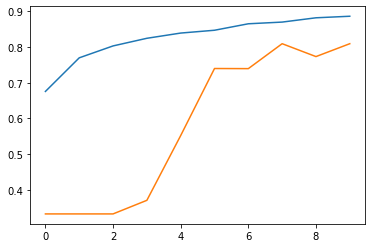

In [14]:
accs = h.history['accuracy']
val_accs = h.history['val_accuracy']

plt.plot(range(len(accs)),accs,label='Training')
plt.plot(range(len(val_accs)),val_accs,label='Validation')

In [15]:
model = tf.keras.models.load_model('models/model_ 0.809.h5')

In [16]:
preds = model.predict(x_test/255.)

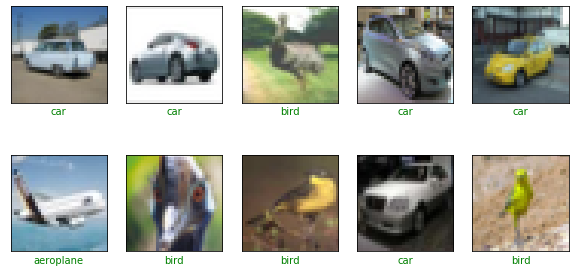

In [17]:
show_random_examples(x_test,y_test,preds) #show bunch of random examples for every tun

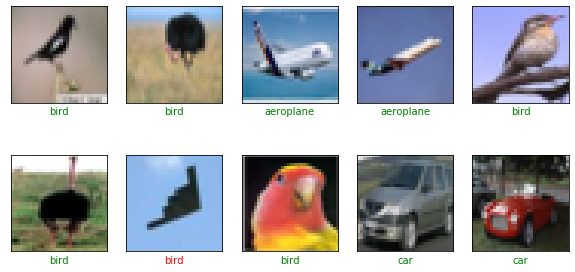

In [20]:
show_random_examples(x_test,y_test,preds)